In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from os import path
import numpy as np
import cv2 as cv
import trimesh
import sys
import os

# Required to import local modules
repo_root = path.abspath(path.join('..', '..'))
if repo_root not in sys.path:
    sys.path.append(repo_root)

# Our local modules
import ds_tools.calibration.calibrate as clb
from ds_tools.shared import util, cv_util, mesh_util, plot_util, transform as tf

# Load the calibration image and mark relevant points

In [2]:
data_dir = util.get_data_dir()
calib_dir = path.join(data_dir, 'placenta_phantom_calib')
calib_imath_path = path.join(calib_dir, 'scan_5.png')

# Positions of the markers in the image listed clockwise,
# starting from the red marker at top left and finishing
# wit the green marker in bottom left
#
# Note: You can mark these points manually using the
#       `mark-points.py` script
points_2d_raw = np.array([
    [136, 309, 610, 700, 295, 98],
    [86, 79, 120, 492, 520, 531]
])
point_count = points_2d_raw.shape[1]

# Define point colours explicitly - makes it easier to
# ensure the image-points <-> mesh-points mapping is
# correct
point_colours = ['red', 'black', 'gray', 'yellow', 'blue', 'green']

<IPython.core.display.Javascript object>


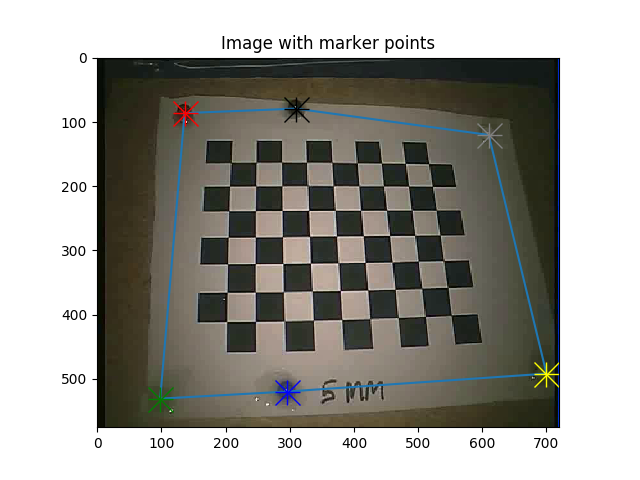

In [3]:
image_raw = cv.imread(calib_imath_path)
image_raw = cv.cvtColor(image_raw, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_title('Image with marker points')
ax.imshow(image_raw)
plot_util.draw_2d_points(ax, points_2d_raw, colour=point_colours,
                    connect=True, size=18)

# Load camera intrinsics and rectified the image

<IPython.core.display.Javascript object>


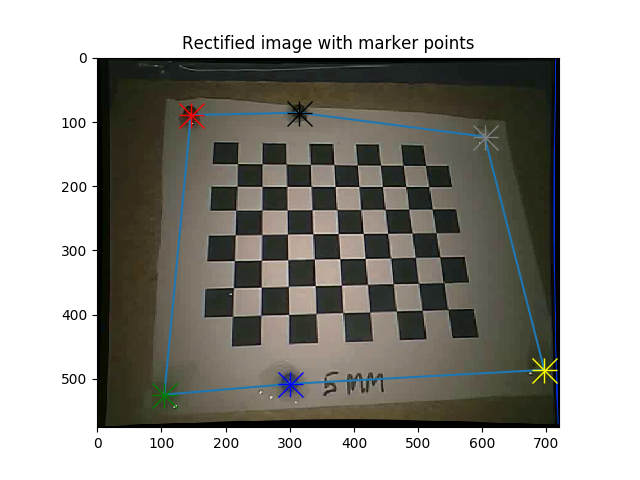

In [4]:
intrinsics_file = path.join(data_dir, 'refined_intrinsics.json')
cam_matrix, dist_coeffs, width, height = util.load_intrinsics(intrinsics_file)

h, w = image_raw.shape[:2]
new_cam_matrix, roi = cv.getOptimalNewCameraMatrix(cam_matrix, dist_coeffs,
                                                   (w, h), 1, (w, h))

image = cv.undistort(image_raw, cam_matrix, dist_coeffs, None, new_cam_matrix)
points_2d = cv_util.undistort_line(points_2d_raw, cam_matrix,
                                      dist_coeffs, new_cam_matrix)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_title('Rectified image with marker points')
ax.imshow(image)
plot_util.draw_2d_points(ax, points_2d, colour=point_colours,
                    connect=True, size=18)

# Load relevant meshes

In [5]:
# Define mesh paths
brd_markers_file = path.join(calib_dir, 'calib_markers.stl')
end_markers_file = path.join(calib_dir, 'endo_markers.stl')

# Load the meshes
brd_markers_joint = trimesh.load(brd_markers_file)
end_markers_joint = trimesh.load(end_markers_file)

# Get centroids for all calibration board and endoscope markers and ensure that the order is correct

In [6]:
brd_centroids_unordered = mesh_util.extract_marker_mesh_centroids(brd_markers_joint)
end_centroids = mesh_util.extract_marker_mesh_centroids(end_markers_joint)

# points_3d = np.array(brd_centroids_unordered).T
# plane_normal = tf.find_plane_normal(points_3d)
# centroid = np.mean(points_3d, axis=1)

# end_points_3d = np.array(end_centroids).T

# _, ax = plot_util.prepare_3d_plot(title='Calibration markers')
# plot_util.draw_3d_points(ax, points_3d, colour=point_colours, connect=True, size=30)
# plot_util.draw_3d_points(ax, end_points_3d, colour='purple')

# Reorder the points based on their coordinates in the visualisation below.
# Note that the order must match that of `img_points_cart`
brd_centroids = [None] * len(brd_centroids_unordered)
for centroid in brd_centroids_unordered:
    x, y, z = centroid
    if z < -40:
        # Bottom row
        if x > -230:
            brd_centroids[5] = centroid # Green marker
        elif x < -260:
            brd_centroids[3] = centroid # Yellow marker
        else:
            brd_centroids[4] = centroid # Blue marker
    else:
        # Top row
        if x > -230:
            brd_centroids[0] = centroid # Red marker
        elif x < -260:
            brd_centroids[2] = centroid # White marker
        else:
            brd_centroids[1] = centroid # Black marker
        

# Refine and visualise the points

<IPython.core.display.Javascript object>


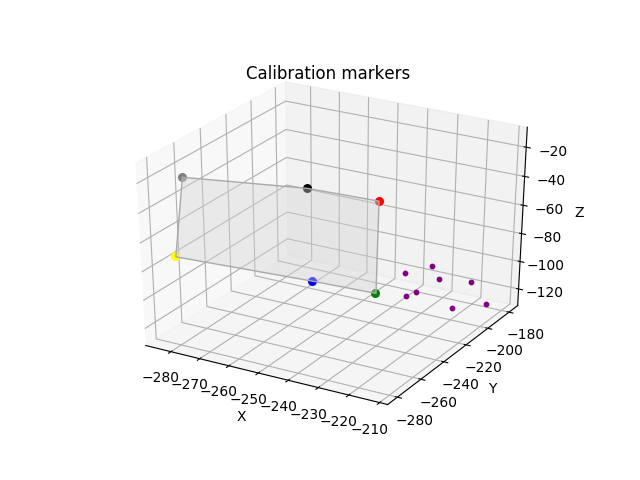

In [7]:
points_3d = np.array(brd_centroids).T
plane_normal = tf.find_plane_normal(points_3d)
centroid = np.mean(points_3d, axis=1)

end_points_3d = np.array(end_centroids).T

_, ax = plot_util.prepare_3d_plot(title='Calibration markers')
plot_util.draw_3d_points(ax, points_3d, colour=point_colours, connect=True, size=30)
plot_util.draw_3d_points(ax, end_points_3d, colour='purple')

# Estimate camera extrinsics from 2D-3D point correspondence

<IPython.core.display.Javascript object>


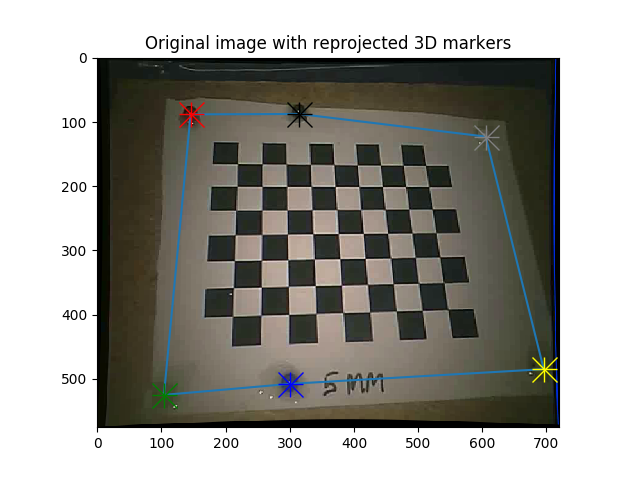

In [8]:
ret, rvec, tvec = cv.solvePnP(points_3d.T, points_2d.T, new_cam_matrix, None)
cv_points_2d = cv.projectPoints(points_3d.T, rvec, tvec, new_cam_matrix, None)[0]
new_points_2d = cv_points_2d[:, 0, :].T

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_title('Original image with reprojected 3D markers')
ax.imshow(image)
plot_util.draw_2d_points(ax, new_points_2d, colour=point_colours,
                    connect=True, size=18)

# Draw camera alongside the meshes

<IPython.core.display.Javascript object>


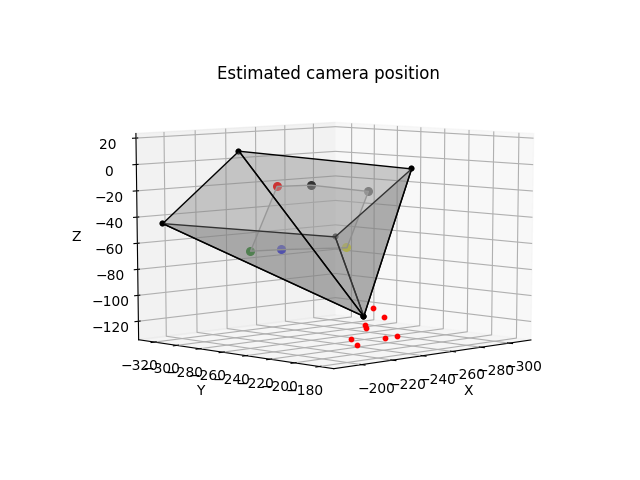

In [15]:
# Right now `rvec` and `tvec` represent the transform FROM the world
# reference frame TO camera reference frame.
R = cv.Rodrigues(rvec)[0]
t = tvec.reshape(3, 1)
T_world_to_cam = tf.to_transform(R, t)


# For visualisation purposes, we need a transform FROM camera
# frame TO world frame
T_cam_to_world = np.linalg.inv(T_world_to_cam)
_, ax = plot_util.prepare_3d_plot(title='Estimated camera position')
plot_util.draw_3d_points(ax, points_3d, colour=point_colours, connect=True, size=30)
plot_util.draw_3d_points(ax, end_points_3d, colour='red')
plot_util.draw_3d_camera(ax, w, h, new_cam_matrix, T_cam_to_world, z=120)

# Find transformation between endoscope rigid body and camera

In [10]:
# Load reference endoscope markers
extrinsics_file = path.join(data_dir, 'extrinsics.json')
_, endoscope_markers = util.load_extrinsics(extrinsics_file)

In [11]:
T_rigid_to_world = clb.calc_rigid_body_transform(endoscope_markers, end_points_3d)
T_rigid_to_cam = T_world_to_cam @ T_rigid_to_world

# Draw camera with the reference endoscope markers

If everything is correct, the camera should appear in the same orientation with the original (reference) endoscope markers as it is with the markers ion the previous 3D plot.

<IPython.core.display.Javascript object>


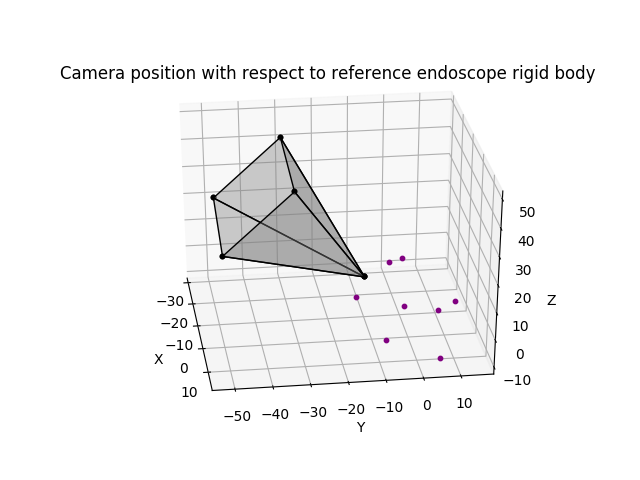

In [12]:
T_cam_to_rigid = np.linalg.inv(T_rigid_to_cam)
_, ax = plot_util.prepare_3d_plot(title='Camera position with respect to reference endoscope rigid body')
plot_util.draw_3d_points(ax, endoscope_markers, colour='purple')
plot_util.draw_3d_camera(ax, w, h, new_cam_matrix, T_cam_to_rigid, z=40)

# Store the relevant transform in JSON

In [13]:
# We want to store the transfrom FROM points in endoscope reference frame 
# TO the camera refernece frame
util.save_extrinsics(extrinsics_file, 
                     transform=T_rigid_to_cam,
                     endoscope_markers=endoscope_markers)